# Group 1 Capstone Project Work
### Make sure to make / checkout your own branch before making changes

# Maddie Hince

In [10]:
import pandas as pd
import sqlite3

df = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
df.head()


conn = sqlite3.connect('zippedData/im.db.zip')
pd.read_sql("""SELECT *""")

DatabaseError: Execution failed on sql '
SELECT *
FROM im
': file is not a database

# Cat Murad

Looking at genres & their ratings

In [178]:
import pandas as pd
import sqlite3

#### Looking at movie info csv file

In [181]:
# read in csv file
df_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', delimiter='\t')

# drop null values from dataframe
df_info.dropna(inplace=True)
df_info.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
6,10,Some cast and crew from NBC's highly acclaimed...,PG-13,Comedy,Jake Kasdan,Mike White,"Jan 11, 2002","Jun 18, 2002",$,"41,032,915",82 minutes,Paramount Pictures
7,13,"Stewart Kane, an Irishman living in the Austra...",R,Drama,Ray Lawrence,Raymond Carver|Beatrix Christian,"Apr 27, 2006","Oct 2, 2007",$,"224,114",123 minutes,Sony Pictures Classics
15,22,Two-time Academy Award Winner Kevin Spacey giv...,R,Comedy|Drama|Mystery and Suspense,George Hickenlooper,Norman Snider,"Dec 17, 2010","Apr 5, 2011",$,"1,039,869",108 minutes,ATO Pictures
18,25,"From ancient Japan's most enduring tale, the e...",PG-13,Action and Adventure|Drama|Science Fiction and...,Carl Erik Rinsch,Chris Morgan|Hossein Amini,"Dec 25, 2013","Apr 1, 2014",$,"20,518,224",127 minutes,Universal Pictures


In [182]:
df_info['box_office'] = df_info['box_office'].str.replace(",","")   #replacing commas, so box office numbers can be read as an integer
df_info['box_office'] = df_info['box_office'].astype(int)

In [199]:
df_sorted = df_info.sort_values(by='box_office', ascending=False)   # sort box_office numbers - can see which genre has done the best in our dataset

In [205]:
df_sorted.head(2)

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
827,1071,This depiction of the last 12 hours in the lif...,R,Drama,Mel Gibson,Mel Gibson|Benedict Fitzgerald,"Feb 25, 2004","Aug 31, 2004",$,368000000,127 minutes,Newmarket Film Group
877,1136,The Hobbit: An Unexpected Journey follows titl...,PG-13,Action and Adventure|Science Fiction and Fantasy,Peter Jackson,Peter Jackson|Philippa Boyens|Guillermo del To...,"Dec 14, 2012","Mar 19, 2013",$,303001229,170 minutes,Warner Bros.


#### Taking a look at the SQL movie database

In [5]:
conn = sqlite3.connect('im.db')

In [30]:
pd.read_sql('select * from movie_akas', conn) #select all from the movie_akas table

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.0
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None,0.0
...,...,...,...,...,...,...,...,...
331698,tt9827784,2,Sayonara kuchibiru,None,None,original,None,1.0
331699,tt9827784,3,Farewell Song,XWW,en,imdbDisplay,None,0.0
331700,tt9880178,1,La atención,None,None,original,None,1.0
331701,tt9880178,2,La atención,ES,None,None,None,0.0


In [13]:
pd.read_sql('select * from movie_basics', conn) #select all from the movie_basics table

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None


SQL Query
* We are selecting the distinct title and genre from the movie basics table
* We are also selecting the average rating from the movie_ratings table
* We are joining these too tables on the movie_id
* grouped by genre and ordered by the average rating

In [208]:
q = pd.read_sql('''select distinct b.primary_title, b.genres, r.averagerating 
        from movie_basics b
        join movie_ratings r
            on b.movie_id = r.movie_id
        where start_year >= 2010 and b.genres is not Null
        group by genres
        order by averagerating DESC''', conn)
q

,primary_title,genres,averagerating
0,Love on a Leash,"Documentary,Family,Romance",9.7
1,Foosballers,"Comedy,Documentary,Sport",9.7
2,Lost Conquest,"Comedy,Documentary,Fantasy",9.4
3,Sunakali,"Documentary,Family,Musical",9.3
4,The Long Count Teaser,"History,Sport",9.2
...,...,...,...
918,Foodfight!,"Action,Animation,Comedy",1.9
919,The Devil's Flower,"Mystery,Romance",1.7
920,Eyal Hirrifah,"Comedy,Musical,Sport",1.4
921,Futures Past,"Action,Biography,History",1.3


In [206]:
# turning the results of the above query into a dataframe
df = pd.DataFrame(q, columns = ['primary_title', 'genres', 'averagerating'])
print(df.head())

              primary_title                    genres  averagerating
0  42nd Street: The Musical                   Musical            9.1
1               My Champion         Documentary,Sport            9.1
2         Twice Upon a Time    Documentary,Family,War            9.0
3                  The King  Documentary,Family,Sport            8.9
4      Rock in the Red Zone     Documentary,Music,War            8.8


In [99]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0, 0.5, 'Rating')

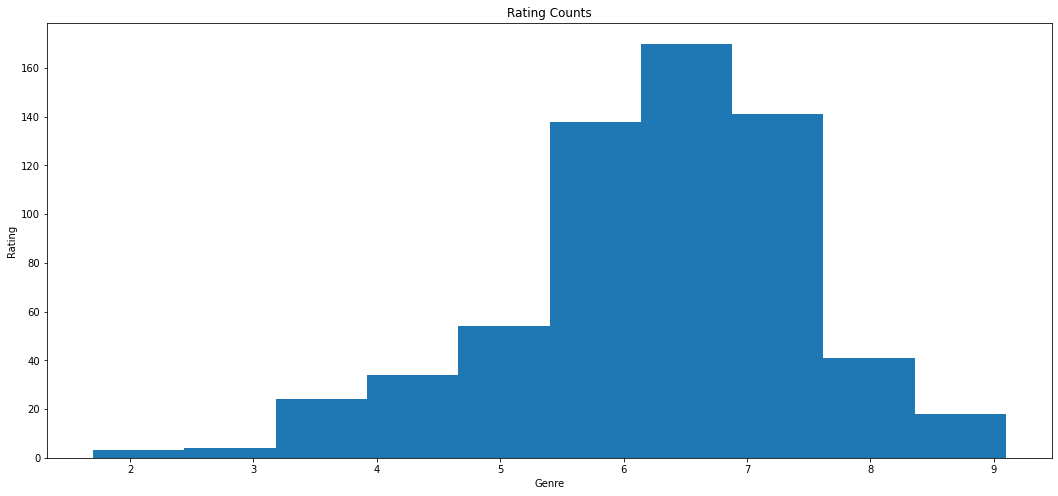

In [123]:
# Plot the ratings and their counts

fig, ax = plt.subplots(figsize=(18, 8)) # Two figures side by side
#ax_lft = axes[0]
#df['averagerating'].hist()
ax.hist(df['averagerating'])
ax.set_title('Rating Counts')
ax.set_xlabel('Genre')
ax.set_ylabel('Rating')

In [128]:
pd.read_sql('''select avg(averagerating) from movie_ratings''', conn)

,avg(averagerating)
0,6.332729


# Elijah Soba

# Luis Estrada 

# Kilmar Lazo 

# Michael Eugene